##Analyses text to get tags

In [ ]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics.pairwise import cosine_similarity
import re

# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Read the CSV file
df = pd.read_csv('Questions.csv')
df['Tags'].fillna('', inplace=True)

# Function to parse tags
def parse_tags(tag_string):
    if isinstance(tag_string, str):
        return re.findall(r'<(.*?)>', tag_string)
    else:
        return []

df['Tags'] = df['Tags'].apply(parse_tags)

# Limit to the first 500 rows
df = df.head(500)

# Function to get BERT embeddings in batches to save memory
def get_bert_embeddings(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)  # Use the mean of the hidden states
        embeddings.append(batch_embeddings)
    return torch.cat(embeddings, dim=0)

# Precompute BERT embeddings for the 'Body' texts
embeddings = get_bert_embeddings(df['Body'].tolist())

def get_associated_tags(input_string, top_n=5):
    input_embedding = get_bert_embeddings([input_string])
    similarities = cosine_similarity(input_embedding, embeddings).flatten()
    top_indices = similarities.argsort()[-top_n:][::-1]
    associated_tags = df.iloc[top_indices]['Tags']
    return associated_tags

# Example usage:
input_string = input("Enter a string: ")
top_n = 5  # Number of top similar texts to consider
tags = get_associated_tags(input_string, top_n)
print("Associated Tags for top {} similar texts:".format(top_n))
for i, tag_list in enumerate(tags, 1):
    print(f"{i}. {tag_list}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Enter a string: ruby
Associated Tags for top 5 similar texts:
1. ['ruby', 'shell', 'interop']
2. ['linux', 'editor']
3. ['html', 'forms', 'browser', 'autocomplete']
4. ['flash', 'graph']
5. ['c#', 'asp.net-mvc', 'visual-studio']


In [ ]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics.pairwise import cosine_similarity
import re

In [ ]:
# Read the CSV file
df = pd.read_csv('Questions.csv')
df['Tags'].fillna('', inplace=True)

# Function to parse tags
def parse_tags(tag_string):
    if isinstance(tag_string, str):
        return re.findall(r'<(.*?)>', tag_string)
    else:
        return []

df['Tags'] = df['Tags'].apply(parse_tags)

# Limit to the first 500 rows
df = df.head(500)

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

# Load NLTK stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    pattern = r'<|p>|>|(?:https?://)?[\w.-]+[,.](?:com|in|org)'

    # Remove the specified strings and links
    text = re.sub(pattern, '', text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and irrelevant terms
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Apply text preprocessing to the 'Body' column
df['Cleaned_Body'] = df['Body'].apply(preprocess_text)

# Function to extract entities from text using NER (Placeholder implementation)
def extract_entities(text):
    # For demonstration, let's split the text into words and use them as entities
    return text.split()

# Apply entity extraction to the 'Cleaned_Body' column
df['Entities'] = df['Cleaned_Body'].apply(extract_entities)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print(df['Entities'])

0      [How, page, collection, LINQ, given, codestart...
1      [I, want, format, existing, comments, 'RDoc, c...
2      [The, version, strongSubclipse, (, 1.2.4, ), /...
3      [I, 've, written, database, generation, script...
4      [What, best, practices, around, creating, flat...
                             ...                        
495    [Does, anyone, good, hints, writing, test, cod...
496    [Occasionally, ,, I, 've, come, across, webpag...
497    [I, working, emJXTA/em, 2.3, last, year, peer-...
498    [Python, works, multiple, platforms, used, des...
499    [What, difference, href=, '', /en-us/library/9...
Name: Entities, Length: 500, dtype: object


##Constructs graph

In [ ]:
import itertools

# Step 1: Calculate similarity scores
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Entities'].apply(lambda x: ' '.join(x)))
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 2: Determine related tags
related_tags = {}
for i, row in enumerate(similarity_matrix):
    related_tags[i] = set()
    for j, score in enumerate(row):
        if i != j and score > 0.3:
            related_tags[i].add(j)

In [ ]:
# Step 3: Create graph
G = nx.Graph()
# Add nodes
for tags in df['Tags']:
    for tag in tags:
        G.add_node(tag)
# Add edges between tags in the same row
for tags in df['Tags']:
    for tag1, tag2 in itertools.combinations(tags, 2):
        G.add_edge(tag1, tag2)
# Add edges between related tags
for i, related in related_tags.items():
    tags_i = df['Tags'][i]
    for j in related:
        tags_j = df['Tags'][j]
        for tag1, tag2 in itertools.product(tags_i, tags_j):
            G.add_edge(tag1, tag2)

In [ ]:
def print_connected_nodes(graph, node):
    print(f"Nodes connected to '{node}':")
    neighbors = graph.neighbors(node)
    for neighbor in neighbors:
        print(neighbor)

# Example usage
node_to_check = 'deep-learning'
print_connected_nodes(G, node_to_check)

Nodes connected to 'deep-learning':
python-3.x
numpy
machine-learning
python
conv-neural-network
data-science


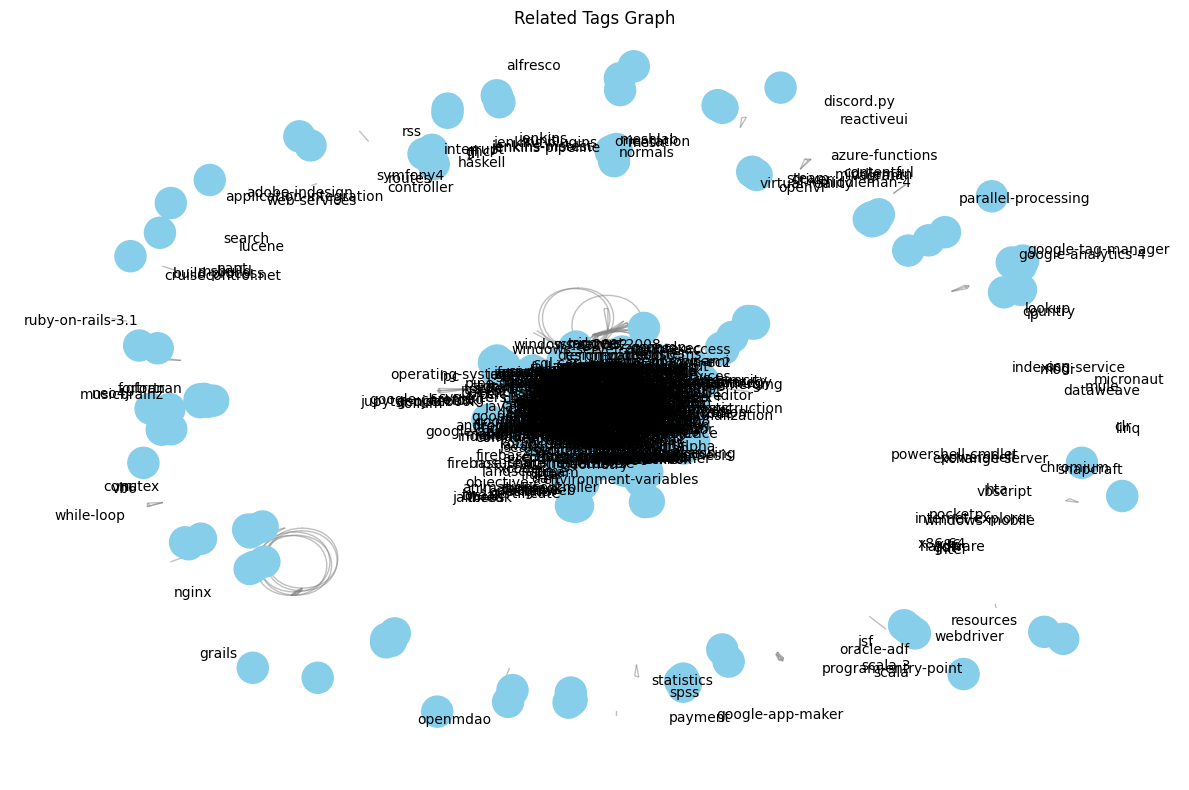

In [ ]:
# Draw the graph
plt.figure(figsize=(12, 8))

# Customize node colors and sizes
node_colors = ['skyblue' for _ in G.nodes()]
node_sizes = [500 for _ in G.nodes()]

# Draw nodes
nx.draw_networkx_nodes(G, pos=nx.spring_layout(G), node_size=node_sizes, node_color=node_colors)

# Draw edges
nx.draw_networkx_edges(G, pos=nx.spring_layout(G), width=1.0, alpha=0.5, edge_color='gray')

# Draw node labels
nx.draw_networkx_labels(G, pos=nx.spring_layout(G), font_size=10, font_family='sans-serif')

plt.title("Related Tags Graph")
plt.axis('off')
plt.tight_layout()


plt.show()


In [ ]:
adjacency_list = nx.to_dict_of_lists(G)
edge_list = nx.to_edgelist(G)
G = nx.Graph(G)

##Similarity matrix calculation using Bert

In [ ]:
!pip install transformers torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_embedding(concept):
    inputs = tokenizer(concept, return_tensors='pt', truncation=True, padding=True, max_length=10)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

embeddings = {}
for node in G.nodes:
    embeddings[node] = get_embedding(node)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
from scipy.sparse import lil_matrix
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

num_nodes = len(G.nodes)
similarity_matrix = lil_matrix((num_nodes, num_nodes))
nodes = list(G.nodes)
node_index = {node: idx for idx, node in enumerate(nodes)}

for edge in G.edges:
    idx1, idx2 = node_index[edge[0]], node_index[edge[1]]
    sim = cosine_similarity([embeddings[edge[0]]], [embeddings[edge[1]]])[0, 0]
    similarity_matrix[idx1, idx2] = sim
    similarity_matrix[idx2, idx1] = sim  # Symmetric matrix

NameError: name 'embeddings' is not defined

In [ ]:
print(similarity_matrix)

  (0, 614)	0.7116682529449463
  (1, 2)	0.7475721836090088
  (1, 17)	0.6488051414489746
  (1, 39)	0.3723781108856201
  (1, 40)	0.7615716457366943
  (1, 50)	0.8716109991073608
  (1, 59)	0.8423231244087219
  (1, 60)	0.6729039549827576
  (1, 68)	0.8207183480262756
  (1, 70)	0.778395414352417
  (1, 77)	0.6039755344390869
  (1, 108)	0.8064061403274536
  (1, 109)	0.6983959674835205
  (1, 176)	0.6103383302688599
  (1, 353)	0.8951200842857361
  (1, 411)	0.43455713987350464
  (1, 412)	0.4962216019630432
  (1, 487)	0.9088219404220581
  (2, 1)	0.7475721836090088
  (3, 4)	0.7198894619941711
  (3, 5)	0.6605194807052612
  (3, 6)	0.4441184997558594
  (3, 7)	0.5450364351272583
  (3, 10)	0.7012661695480347
  (3, 91)	0.5547188520431519
  (3, 106)	0.6126894950866699
  (3, 107)	0.36444181203842163
  (3, 457)	0.480914831161499
  (3, 458)	0.7275527715682983
  (3, 459)	0.4597257971763611
  (4, 3)	0.7198894619941711
  (4, 5)	0.6732864379882812
  (4, 6)	0.5332071781158447
  (4, 19)	0.6049372553825378
  (4, 20)	

In [ ]:
for edge in edge_list:
    print(edge)

Streaming output truncated to the last 5000 lines.
('forms', 'asp.net-core-webapi', {})
('forms', 'azure-redis-cache', {})
('forms', 'graph', {})
('forms', 'data-visualization', {})
('forms', 'nodes', {})
('forms', 'socket.io', {})
('forms', 'ejs', {})
('forms', 'aggregate', {})
('forms', 'menu', {})
('forms', 'navigation', {})
('forms', 'nav', {})
('forms', 'postgresql', {})
('forms', 'sed', {})
('forms', 'psql', {})
('forms', 'excel', {})
('forms', 'vba', {})
('forms', 'date', {})
('forms', 'databricks', {})
('forms', 'android', {})
('forms', 'expo', {})
('forms', 'vue.js', {})
('forms', 'vuetify.js', {})
('forms', 'v-select', {})
('forms', 'v-autocomplete', {})
('forms', 'adodb', {})
('forms', 'axios', {})
('forms', 'permissions', {})
('forms', 'discord', {})
('forms', 'discord.js', {})
('forms', 'dom', {})
('forms', 'html-table', {})
('forms', 'bootstrap-4', {})
('forms', 'foreach', {})
('forms', 'text', {})
('forms', 'react-router', {})
('forms', 'react-router-dom', {})
('forms', 

In [ ]:
print(len(edge_list))

7678


##4-bit Model

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

In [ ]:
!pip install --upgrade transformers

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-7b-it-bnb-4bit", # Instruct version of Gemma 7b
    "unsloth/gemma-2b-bnb-4bit",
    "unsloth/gemma-2b-it-bnb-4bit", # Instruct version of Gemma 2b
    "unsloth/llama-3-8b-bnb-4bit", # [NEW] 15 Trillion token Llama-3
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept {concept1} compared to concept {concept2}, where -5 means {concept1} is much more difficult, and 5 means {concept2} is much more difficult? Your answer should be ONLY a float value.

### Input:
{concept1}: {concept1}
{concept2}: {concept2}

### Response:
{response}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    concept1s = examples["concept1"]
    concept2s = examples["concept2"]
    texts = []
    for concept1, concept2 in zip(concept1s, concept2s):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(concept1=concept1, concept2=concept2, response="") + EOS_TOKEN
        texts.append(text)
    return {"text": texts}

###Sample output

In [ ]:
con1 = "Python"
con2 = "Django"

# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
    [
        alpaca_prompt.format(
            concept1=con1,
            concept2=con2,
            response=""  # output - leave this blank for generation!
        )
    ],
    return_tensors="pt"
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept Python compared to concept Django, where -5 means Python is much more difficult, and 5 means Django is much more difficult? Your answer should be ONLY a float value.

### Input:
Python: Python
Django: Django

### Response:
2.0
<|end_of_text|>


In [ ]:
import re
responses = []
nf = 0

# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
for edge in edge_list:
    concept1, concept2 = edge[0], edge[1]
    query = alpaca_prompt.format(concept1=concept1, concept2=concept2, response="")
    inputs = tokenizer([query], return_tensors="pt").to("cuda")

    from transformers import TextStreamer
    text_streamer = TextStreamer(tokenizer)
    output = model.generate(**inputs, streamer=text_streamer, max_new_tokens=512)
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    pattern = r"### Response:\n([-+]?\d*\.\d+|\d+)"
    #print(llm_response)
    match = re.search(pattern, response)
    global rating
    # If a match is found, extract and convert the matched value to a float
    if match:
        rating = float(match.group(1))
        print("rating: ", rating)
    else:
        print("Rating not found")
        nf += 1
        rating = None
    if rating is not None:
        responses.append((concept1, concept2, rating))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept linq compared to concept clr, where -5 means linq is much more difficult, and 5 means clr is much more difficult? Your answer should be ONLY a float value.

### Input:
linq: linq
clr: clr

### Response:
-2.5
<|end_of_text|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


rating:  -2.5
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept ruby compared to concept rdoc, where -5 means ruby is much more difficult, and 5 means rdoc is much more difficult? Your answer should be ONLY a float value.

### Input:
ruby: ruby
rdoc: rdoc

### Response:
1.0
<|end_of_text|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


rating:  1.0
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept ruby compared to concept ruby-on-rails, where -5 means ruby is much more difficult, and 5 means ruby-on-rails is much more difficult? Your answer should be ONLY a float value.

### Input:
ruby: ruby
ruby-on-rails: ruby-on-rails

### Response:
<|end_of_text|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Rating not found
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept ruby compared to concept http, where -5 means ruby is much more difficult, and 5 means http is much more difficult? Your answer should be ONLY a float value.

### Input:
ruby: ruby
http: http

### Response:
0.0
<|end_of_text|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


rating:  0.0
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept ruby compared to concept crash, where -5 means ruby is much more difficult, and 5 means crash is much more difficult? Your answer should be ONLY a float value.

### Input:
ruby: ruby
crash: crash

### Response:
<|end_of_text|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Rating not found
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept ruby compared to concept lambda, where -5 means ruby is much more difficult, and 5 means lambda is much more difficult? Your answer should be ONLY a float value.

### Input:
ruby: ruby
lambda: lambda

### Response:
<|end_of_text|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Rating not found
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept ruby compared to concept proc, where -5 means ruby is much more difficult, and 5 means proc is much more difficult? Your answer should be ONLY a float value.

### Input:
ruby: ruby
proc: proc

### Response:
0.0
<|end_of_text|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


rating:  0.0
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept ruby compared to concept exception, where -5 means ruby is much more difficult, and 5 means exception is much more difficult? Your answer should be ONLY a float value.

### Input:
ruby: ruby
exception: exception

### Response:
2.5
<|end_of_text|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


rating:  2.5
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept ruby compared to concept plugins, where -5 means ruby is much more difficult, and 5 means plugins is much more difficult? Your answer should be ONLY a float value.

### Input:
ruby: ruby
plugins: plugins

### Response:
ruby: 1.0
plugins: -1.0
<|end_of_text|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Rating not found
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept ruby compared to concept shell, where -5 means ruby is much more difficult, and 5 means shell is much more difficult? Your answer should be ONLY a float value.

### Input:
ruby: ruby
shell: shell

### Response:
-5.0
<|end_of_text|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


rating:  -5.0
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept ruby compared to concept interop, where -5 means ruby is much more difficult, and 5 means interop is much more difficult? Your answer should be ONLY a float value.

### Input:
ruby: ruby
interop: interop

### Response:
<|end_of_text|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Rating not found
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept ruby compared to concept arrays, where -5 means ruby is much more difficult, and 5 means arrays is much more difficult? Your answer should be ONLY a float value.

### Input:
ruby: ruby
arrays: arrays

### Response:
5.0
<|end_of_text|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


rating:  5.0
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept ruby compared to concept ruby-hash, where -5 means ruby is much more difficult, and 5 means ruby-hash is much more difficult? Your answer should be ONLY a float value.

### Input:
ruby: ruby
ruby-hash: ruby-hash

### Response:
<|end_of_text|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Rating not found
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept ruby compared to concept sockets, where -5 means ruby is much more difficult, and 5 means sockets is much more difficult? Your answer should be ONLY a float value.

### Input:
ruby: ruby
sockets: sockets

### Response:
1.0
<|end_of_text|>
rating: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 1.0
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept ruby compared to concept dns, where -5 means ruby is much more difficult, and 5 means dns is much more difficult? Your answer should be ONLY a float value.

### Input:
ruby: ruby
dns: dns

### Response:
0.5
<|end_of_text|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


rating:  0.5
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
On a scale of -5 to 5, how would you rate the relative difficulty of concept ruby compared to concept nslookup, where -5 means ruby is much more difficult, and 5 means nslookup is much more difficult? Your answer should be ONLY a float value.

### Input:
ruby: ruby
nslookup: nslookup

### Response:


KeyboardInterrupt: 

In [ ]:
print(nf)

###Saves the responses in a csv

In [ ]:
# Convert the list of tuples to a DataFrame
df = pd.DataFrame(responses, columns=["Concept1", "Concept2", "Rating"])

# Save the DataFrame to a CSV file
df.to_csv('responses.csv', index=False)

NameError: name 'responses' is not defined

In [ ]:
df_loaded = pd.read_csv('responses.csv')

# Convert the DataFrame to a list of tuples
responses = df_loaded.to_records(index=False).tolist()

In [ ]:
import numpy as np
from scipy.sparse import lil_matrix

num_nodes = len(G.nodes)
pairwise_comparison_matrix = lil_matrix((num_nodes, num_nodes))
nodes = list(G.nodes)
node_index = {node: idx for idx, node in enumerate(nodes)}

for concept1, concept2, rating in responses:
    idx1, idx2 = node_index[concept1], node_index[concept2]
    pairwise_comparison_matrix[idx1, idx2] = rating
    pairwise_comparison_matrix[idx2, idx1] = -rating  # Assuming symmetrical but opposite ratings

In [ ]:
def scale_pairwise_matrix(pairwise_matrix):
    # Convert the lil_matrix to a dense numpy array
    dense_matrix = pairwise_matrix.toarray()

    # Scale the dense matrix between 1 and 10
    min_rating = dense_matrix.min()
    max_rating = dense_matrix.max()

    scaled_matrix = 1 + (dense_matrix - min_rating) * 9 / (max_rating - min_rating)

    # Convert the scaled dense matrix back to a lil_matrix
    scaled_lil_matrix = lil_matrix(scaled_matrix)

    return scaled_lil_matrix

In [ ]:
pairwise_matrix = scale_pairwise_matrix(pairwise_comparison_matrix)

##Computing Absolute Difficulty (AHP Algo)

In [ ]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import eigs

In [ ]:
def normalize_pairwise_matrix(pairwise_matrix):
    col_sums = pairwise_matrix.sum(axis=0)
    normalized_matrix = pairwise_matrix / col_sums
    return normalized_matrix

In [ ]:
normalized_matrix = normalize_pairwise_matrix(pairwise_matrix)

In [ ]:
def compute_priority_vector(normalized_matrix):
    eigenvalues, eigenvectors = eigs(normalized_matrix.T, k=1, which='LR')
    priority_vector = np.abs(eigenvectors[:, 0].real)
    priority_vector /= np.sum(priority_vector)  # Normalize the priority vector
    return priority_vector

In [ ]:
def check_consistency(pairwise_matrix, priority_vector):
    col_sums = pairwise_matrix.sum(axis=0)
    weighted_sum = np.dot(col_sums, priority_vector)
    consistency_index = (weighted_sum - len(priority_vector)) / (len(priority_vector) - 1)
    random_index = 0.58  # Random index for matrices of size 10
    consistency_ratio = consistency_index / random_index
    return consistency_ratio

In [ ]:
def assign_absolute_ratings(priority_vector, scale=(0, 10)):
    min_scale, max_scale = scale
    min_priority = np.min(priority_vector)
    max_priority = np.max(priority_vector)
    absolute_ratings = min_scale + ((priority_vector - min_priority) * (max_scale - min_scale)) / (max_priority - min_priority)
    return absolute_ratings

In [ ]:
def normalize_absolute_ratings(absolute_ratings, new_scale=(0, 10)):
    min_scale, max_scale = new_scale
    min_rating = np.min(absolute_ratings)
    max_rating = np.max(absolute_ratings)
    normalized_ratings = min_scale + ((absolute_ratings - min_rating) * (max_scale - min_scale)) / (max_rating - min_rating)
    return normalized_ratings

In [ ]:
print("Shape of normalized_matrix:", normalized_matrix.shape)
print("Values in normalized_matrix:\n", normalized_matrix)

Shape of normalized_matrix: (756, 756)
Values in normalized_matrix:
   (0, 0)	0.001322751322751323
  (0, 1)	0.0013287912831291826
  (0, 2)	0.0013221789509111014
  (0, 3)	0.001326282334160451
  (0, 4)	0.0013247585326492763
  (0, 5)	0.001322465074899613
  (0, 6)	0.00132189295070541
  (0, 7)	0.0013234674848102027
  (0, 8)	0.0013214641823140038
  (0, 9)	0.001323180926948384
  (0, 10)	0.0013318319954475563
  (0, 11)	0.0013247585326492763
  (0, 12)	0.0013220359353404243
  (0, 13)	0.0013221789509111014
  (0, 14)	0.001326771843489169
  (0, 15)	0.0013243279035889289
  (0, 16)	0.0013213213213213212
  (0, 17)	0.0013214641823140042
  (0, 18)	0.0013204648036108711
  (0, 19)	0.0013236108102904723
  (0, 20)	0.0013226081833375416
  (0, 21)	0.0013210356919825144
  (0, 22)	0.0013244714154987236
  (0, 23)	0.001323180926948384
  (0, 24)	0.001322465074899613
  :	:
  (755, 731)	0.001323180926948384
  (755, 732)	0.0013226081833375414
  (755, 733)	0.001322465074899613
  (755, 734)	0.0013221789509111014
  (755

In [ ]:
# Compute the priority vector
priority_vector = compute_priority_vector(normalized_matrix)

# Check for consistency
consistency_ratio = check_consistency(pairwise_comparison_matrix, priority_vector)

# Assign absolute difficulty ratings
absolute_ratings = assign_absolute_ratings(priority_vector)
normalized_ratings = normalize_absolute_ratings(absolute_ratings)

In [ ]:
print(normalized_ratings)

[ 2.4  4.   6.4  2.8  2.8  4.   2.8  6.   5.2  3.2  5.6  3.2  0.8  6.4
  2.8  4.4  5.2  5.6  3.2  1.2  0.8  4.4  2.8  3.6  4.   7.2  3.2  2.8
  4.   5.2  6.4  1.2  4.4  3.6  0.8  6.8  1.6  9.2  2.4  4.4  4.4  3.6
  2.4  1.6  2.8  3.2  5.2  6.   3.6  3.6  7.2  2.4  1.6  6.4  4.4  0.4
  1.2  3.6  4.4  5.2  6.   1.2  0.   5.2  1.6  6.8  3.6  5.2  1.2  5.2
  4.   2.4  2.4  3.2  1.6  3.6  6.8  5.2  5.6  6.   2.4  7.2  6.4  0.
  1.2  2.4  4.4  3.6  3.2 10.   2.4  2.4  1.2  1.2  3.6  1.2  5.6  6.4
  4.   3.6  0.4  2.4  7.2  5.6  6.8  6.   5.2  3.2  4.4  5.2  4.4  2.8
  4.4  1.6  2.4  4.4  2.4  1.2  5.6  2.4  3.2  2.4  2.4  4.   3.2  0.8
  4.   5.6  6.4  7.2  4.4  3.2  2.8  1.6  1.2  5.6  4.   4.   2.4  2.4
  5.2  6.   3.2  5.2  7.2  1.6  5.6  4.4  6.4  2.4  6.4  5.2  2.8  6.
  2.8  1.6  6.   2.4  6.8  4.4  5.6  4.   7.2  0.8  4.4  6.8  6.4  6.
  6.4  2.8  4.   2.4  1.2  6.4  2.8  3.6  0.4  1.6  6.8  2.4  0.4  2.4
  1.6  5.2  4.   4.4  3.6  6.4  2.4  2.4  5.2  3.2  1.6  4.   3.2  6.
  1.2  6.4

In [ ]:
print(normalized_ratings.shape)

(756,)


##Reconstruction of Graph

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
for i, j in enumerate(nodes):
    print(i, j)

0 linq
1 ruby
2 rdoc
3 eclipse
4 svn
5 aptana
6 subclipse
7 apache-flex
8 actionscript-3
9 air
10 php
11 sql
12 database
13 flat-file
14 linux
15 winapi
16 visual-c++
17 unix
18 timer
19 tortoisesvn
20 branch
21 branching-and-merging
22 performance
23 memory-leaks
24 com-interop
25 windows
26 64-bit
27 c#
28 vb.net
29 ascii
30 hex
31 ios
32 objective-c
33 landscape
34 com
35 vb6
36 internet-explorer
37 windows-mobile
38 pocketpc
39 ruby-on-rails
40 http
41 python
42 macos
43 fonts
44 photoshop
45 web-services
46 winforms
47 data-binding
48 image
49 pdf
50 crash
51 c++
52 random
53 mersenne-twister
54 visual-studio
55 compatibility
56 windows-nt
57 algorithm
58 primes
59 lambda
60 proc
61 versioning
62 asp.net
63 iis
64 authentication
65 active-directory
66 encryption
67 passwords
68 arrays
69 iteration
70 exception
71 mutex
72 oop
73 methods
74 monkeypatching
75 vi
76 viewstate
77 plugins
78 ip
79 lookup
80 country
81 flash
82 adobe
83 macromedia
84 file-locking
85 regex
86 open-source

<ipython-input-23-cc14b5ae1180>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


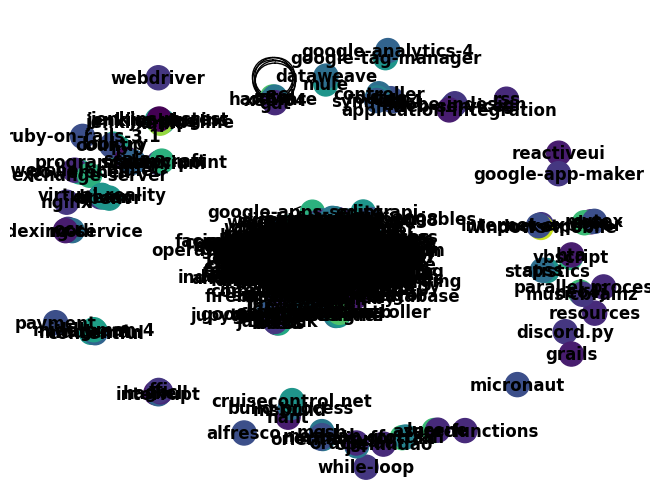

In [ ]:
# Create a dictionary to map concept index to its name
concept_index_to_name = {idx: concept for idx, concept in enumerate(nodes)}

# Create a colormap for the color gradient
cmap = plt.cm.get_cmap('viridis')

# Create a graph
G_colored = nx.Graph()

# Add nodes with colors based on absolute ratings
for idx, concept in enumerate(nodes):
    absolute_rating = normalized_ratings[idx]
    # Map the absolute rating to a color in the colormap
    color = cmap(absolute_rating/10)  # Assuming ratings are normalized to a scale of 0 to 10
    G_colored.add_node(concept, color=color)

# Add edges to the graph
for edge in G.edges:
    G_colored.add_edge(edge[0], edge[1])

# Plot the graph with colored nodes
pos = nx.spring_layout(G_colored)  # You can choose a layout algorithm here
node_colors = [data['color'] for _, data in G_colored.nodes(data=True)]
nx.draw(G_colored, pos, node_color=node_colors, with_labels=True, font_weight='bold')
plt.show()

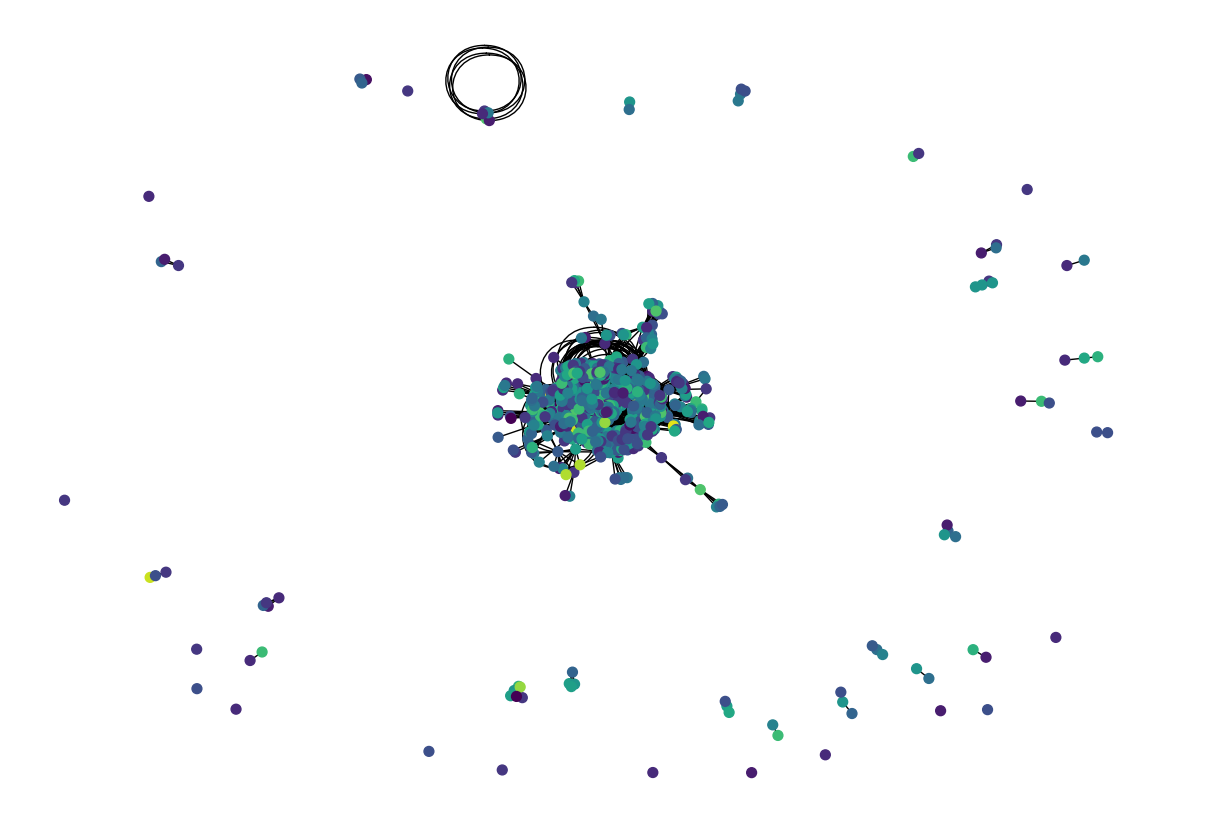

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a graph
G_colored = nx.Graph()

# Add nodes with colors based on absolute ratings
for idx, concept in enumerate(nodes):
    absolute_rating = normalized_ratings[idx]
    # Map the absolute rating to a color in the colormap
    color = cmap(absolute_rating/10)  # Assuming ratings are normalized to a scale of 0 to 10
    G_colored.add_node(concept, color=color)

# Add edges to the graph
for edge in G.edges:
    G_colored.add_edge(edge[0], edge[1])

# Choose a layout algorithm for better spread
pos = nx.spring_layout(G_colored, scale=2)  # Adjust the scale parameter as needed for spread
node_colors = [data['color'] for _, data in G_colored.nodes(data=True)]

# Customize node size and edge width
node_size = 50  # Decrease node size
edge_width = 1.0  # Set edge width

# Plot the graph with colored nodes and edges
plt.figure(figsize=(12, 8))  # Increase figure size for better visualization
nx.draw(G_colored, pos, node_color=node_colors, node_size=node_size, with_labels=False, width=edge_width)
plt.show()

##Path Planning

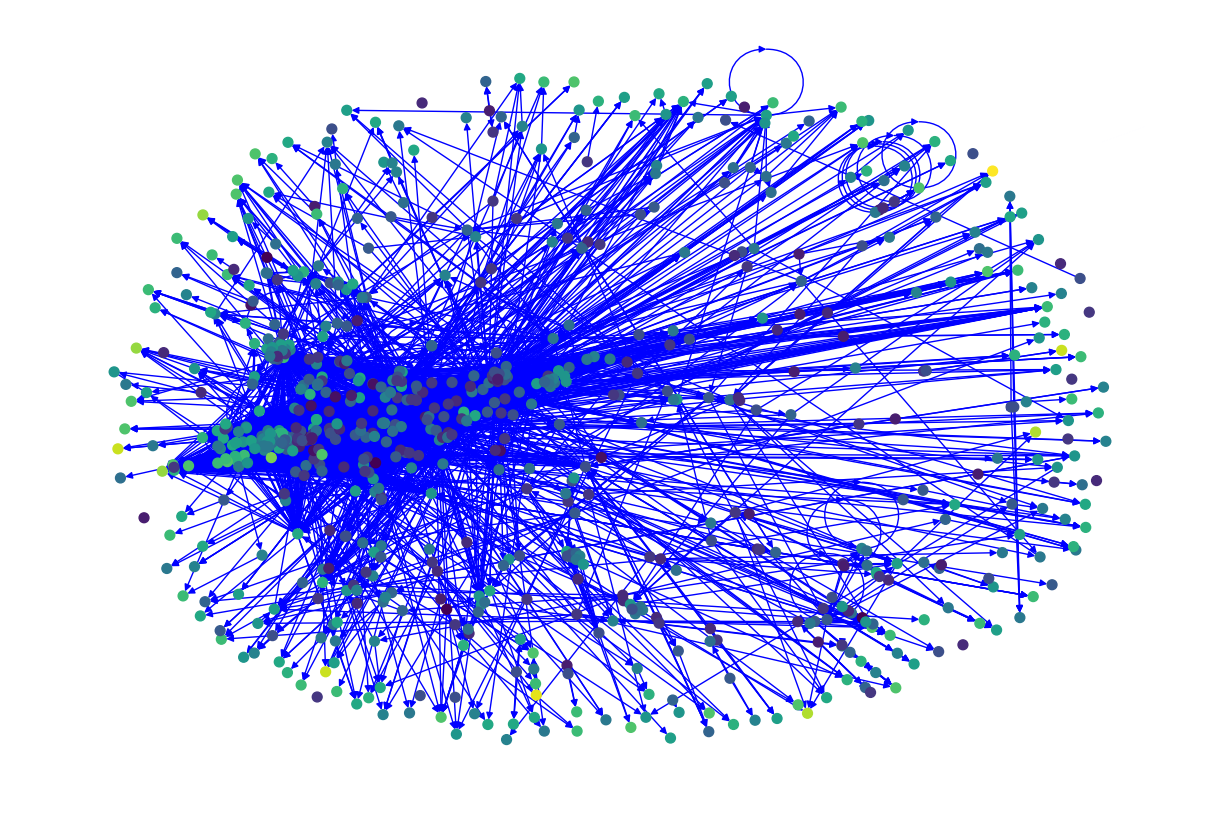

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a new directed graph
G_directed = nx.DiGraph()

# Add nodes with colors based on absolute ratings
for idx, concept in enumerate(nodes):
    absolute_rating = normalized_ratings[idx]
    # Map the absolute rating to a color in the colormap
    color = cmap(absolute_rating/10)  # Assuming ratings are normalized to a scale of 0 to 10
    G_directed.add_node(concept, color=color)

# Add directed edges to the graph
for edge in G.edges:
    source, target = edge
    source_rating = normalized_ratings[nodes.index(source)]
    target_rating = normalized_ratings[nodes.index(target)]
    weight = abs(source_rating - target_rating)
    # Direction of edge is from lower rating to higher rating
    if source_rating <= target_rating:
        G_directed.add_edge(source, target, weight=weight)
    else:
        G_directed.add_edge(target, source, weight=weight)

# Choose a layout algorithm for better spread
pos = nx.spring_layout(G_directed, scale=2)  # Adjust the scale parameter as needed for spread
node_colors = [data['color'] for _, data in G_directed.nodes(data=True)]

# Customize node size and edge width
node_size = 50  # Decrease node size
edge_width = 1.0  # Set edge width

# Plot the graph with colored nodes and weighted edges
plt.figure(figsize=(12, 8))  # Increase figure size for better visualization
nx.draw(G_directed, pos, node_color=node_colors, node_size=node_size, with_labels=False, width=edge_width, edge_color='b', arrows=True)
plt.show()

In [ ]:
def custom_edge_weight(u, v, data):
    num_nodes = len(nx.shortest_path(G_directed, source=u, target=v))   # Number of nodes in the path
    return data['weight'] / num_nodes

In [ ]:
def find_path(source, target):
    try:
        # Find the shortest path with custom edge weight function
        path = nx.dijkstra_path(G_directed, source=source, target=target, weight=custom_edge_weight)
        return path
    except nx.NetworkXNoPath:
        return None